## Model-observations comparisons for ToE study

#### set up paths

In [2]:
feisty_dir = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY'
data_dir = '/glade/derecho/scratch/kristenk/ToE_saved_data'
fig_dir = '/glade/work/kristenk/figs'
mask_dir = '/glade/u/home/kristenk/antarc_marine_pred_work/TOE'
obs_dir = '/glade/work/kristenk'
ice_obs_dir = '/glade/campaign/cesm/development/pcwg/ssmi/CDR'

In [3]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import utils
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7').isel(nlat=slice(0,55))

area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG
lons_norm = utils.normal_lons(lons)
area_km2 = area * 1e-10

In [5]:
ds_grid2 = pop_tools.get_grid('POP_gx1v7')

lats2 = ds_grid2.TLAT
lons2 = ds_grid2.TLONG

### get CESM data for SIC and krill growth and NPP

In [6]:
file = f'{data_dir}/CESM2-LE-seasonal-integrals-KGP.nc'
ds_kgp = xr.open_dataset(file)
ds_kgp = ds_kgp.isel(nlat=slice(0,55))
ds_kgp = ds_kgp.isel(time=slice(70,250))
ds_kgp

<xarray.Dataset>
Dimensions:     (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time        (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    KGP_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    KGP_OND     (time, member_id, nlat, nlon) float64 ...
    KGP_JFM     (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2024-01-23
    contents:        yearly KGP in the Southern Ocean from 1850 to 2099. Each...

In [7]:
file = f'{data_dir}/CESM2-LE-seasonal-integrals-NPP.nc'
ds_npp = xr.open_dataset(file)
ds_npp = ds_npp.isel(time=slice(70,250))
#ds_npp = ds_npp.isel(nlat=slice(0,55))

In [8]:
ds_npp

<xarray.Dataset>
Dimensions:     (member_id: 50, nlat: 384, nlon: 320, time: 180)
Coordinates:
  * time        (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    NPP_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    NPP_OND     (time, member_id, nlat, nlon) float64 ...
    NPP_JFM     (time, member_id, nlat, nlon) float64 ...
    NPP_AMJ     (time, member_id, nlat, nlon) float64 ...
    NPP_JAS     (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2025-03-03
    contents:        yearly NPP in the Southern Ocean from 1850 to 2099. Each...

In [9]:
file = f'{data_dir}/CESM2-LE-seasonal-means-IFRAC-hi_v4.nc'
ds_ice = xr.open_dataset(file)
ds_ice = ds_ice.isel(time=slice(70,250))
ds_ice

<xarray.Dataset>
Dimensions:       (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time          (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    IFRAC_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    IFRAC_OND     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JFM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JAS     (time, member_id, nlat, nlon) float64 ...
    IFRAC_SON     (time, member_id, nlat, nlon) float64 ...
    IFRAC_MAM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_AMJ     (time, member_id, nlat, nlon) float64 ...
    SIT_OND       (time, member_id, nlat, nlon) float64 ...
    SIT_JFM       (time, member_id, nlat, nlon) float64 ...
    SIT_AMJ       (time, member_id, nlat, nlon) float64 ...
    SIT_JAS       (time, member_id, nlat, nlon) float64 ...
    SIT_ONDJFM    (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2025-03-03
    contents:        yearly ifrac in the Southern Ocean from 1850 to 2099. Ea...

In [10]:
### TRIM time to NOAA/NSIDC CDR record, 1979 to 2020

ds_ice.time[59:101].values

array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [11]:
ds_ice = ds_ice.isel(time=slice(59,101))

### get sea ice obs

In [12]:
file = f'{ice_obs_dir}/ssmi_cdr_monthly_data_gx1v5_197901-202012.nc'
ds_sat_ice = xr.open_dataset(file)
ds_sat_ice['time'] = pd.date_range(start="1979-01-01", end="2021-01-01",freq="M")
ds_sat_ice = ds_sat_ice.isel(jdim=slice(0,55))
ds_sat_ice = ds_sat_ice.rename({'jdim' : 'nlat', 'idim' : 'nlon'})

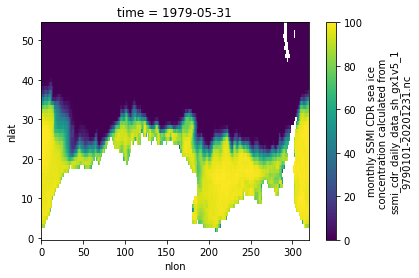

In [11]:
ds_sat_ice.CDR_seaice.isel(time=4).plot()

### Get krillbase
### REF: https://data.bas.ac.uk/full-record.php?id=GB/NERC/BAS/PDC/00915

In [13]:
csv_file = f'{obs_dir}/krillbase/krillbase.csv'
krillbase = pd.read_csv(csv_file)
krillbase[['day','month','year']]=krillbase.Date.str.split("-",expand=True)
krillbase  = krillbase.drop(columns=['Date','Datacaveats','Waterdepthrange(within 10km)'])
krillbase.year = pd.to_numeric(krillbase.year)
krillbase.day = pd.to_numeric(krillbase.day)
krillbase

,Station,Recordtype,Latitude,Longitude,Day/Night,Nettype,Moutharea ofnet (m2),Volumefiltered (m3),Topsamplingdepth (m),Bottomsamplingdepth (m),No. ofkrill under 1m2,Standardisedkrillunder 1m2,N or Sof PolarFront,Waterdepthmean(within 10km),Climatologicaltemperature,day,month,year
0,his1926dis-ver9a,stratified haul,-46.1833,-22.4500,day,N70V net,0.39,NaN,0.0,50.0,NaN,NaN,N,3975.0,9.83,11,FEB,1926
1,his1926dis-ver9b,stratified haul,-46.1833,-22.4500,day,N70V net,0.39,NaN,50.0,100.0,NaN,NaN,N,3975.0,9.83,11,FEB,1926
2,his1926dis-ver9c,stratified haul,-46.1833,-22.4500,day,N70V net,0.39,NaN,100.0,250.0,NaN,NaN,N,3975.0,9.83,11,FEB,1926
3,his1926dis-ver9com,stratified pooled haul,-46.1833,-22.4500,day,N70V net,0.39,NaN,0.0,250.0,NaN,NaN,N,3975.0,9.83,11,FEB,1926
4,his1926dis-ver10a,stratified haul,-46.5833,-24.2500,day,N70V net,0.39,NaN,0.0,50.0,NaN,NaN,N,4513.0,9.35,13,FEB,1926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14538,pal2016lte309,haul,-67.7043,-70.2121,day,2 m fixed frame net,4.00,7160.452,0.0,120.3,0.403,0.960,S,586.0,-0.19,28,JAN,2016
14539,pal2016lte323,haul,-68.2836,-68.5951,day,2 m fixed frame net,4.00,8027.497,0.0,120.0,0.299,0.723,S,452.0,-1.07,30,JAN,2016
14540,pal2016lte395,haul,-65.2143,-64.1640,night,2 m fixed frame net,4.00,8010.604,0.0,120.0,146.730,168.224,S,156.0,-0.16,7,FEB,2016
14541,pal2016lte415,haul,-64.8178,-64.2425,day,2 m fixed frame net,4.00,5564.254,0.0,120.7,15.770,40.788,S,333.0,0.32,7,FEB,2016


### Get aquamaps data for krill, toothfish, and silverfish

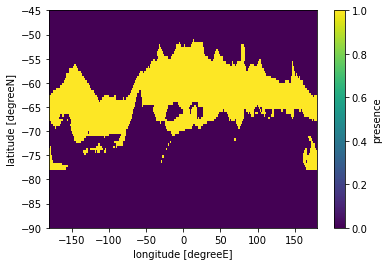

In [14]:
##
ds_aquamaps_krill = xr.open_dataset(f'{obs_dir}/aquamaps/Reviewed_Euphausia_superba_modelgrid_boolean.nc')
ds_aquamaps_krill.presence.plot()

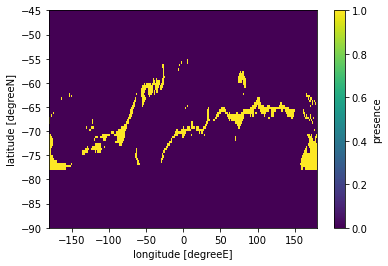

In [15]:
##
ds_aquamaps_toothfish = xr.open_dataset(f'{obs_dir}/aquamaps/Reviewed_Dissostichus_mawsoni_modelgrid_boolean.nc')
ds_aquamaps_toothfish.presence.plot()

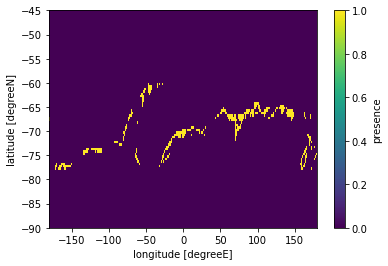

In [16]:
##
ds_aquamaps_silverfish = xr.open_dataset(f'{obs_dir}/aquamaps/Reviewed_Pleuragramma_antarctica_modelgrid_boolean.nc')
ds_aquamaps_silverfish.presence.plot()

### Get the SIZ mask (since this is the only area that we analyzed krill growth)

In [17]:
##
ds_siz_mask = xr.open_dataset(f'{mask_dir}/SIZ_mask_1920-50-CESM2LE_15percentJJA.nc')
ds_siz_mask = ds_siz_mask.isel(nlat=slice(0,55))
ds_siz_mask

<xarray.Dataset>
Dimensions:  (nlat: 55, nlon: 320)
Coordinates:
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    SIZ      (nlat, nlon) float64 ...

### Extract CESM data for the same years as KRILLBASE: 1926 to 2016

In [18]:
cesm_krill_growth =  ds_kgp.KGP_ONDJFM.isel(time=slice(6,96)).mean(dim=('time','member_id')).where(ds_siz_mask.SIZ==1)

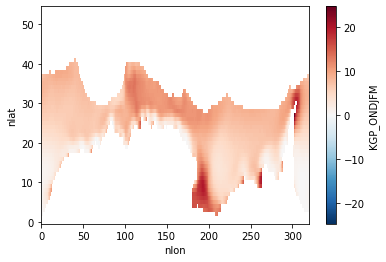

In [19]:
cesm_krill_growth.plot()

In [20]:
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif', size=13)

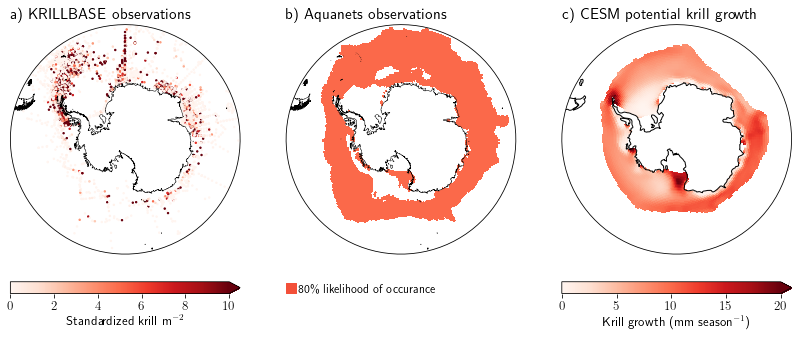

In [22]:
fig = plt.figure(figsize=(14,5))

gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1,1),height_ratios=(1,0.05))

prj =ccrs.SouthPolarStereo()

ax_map1 = plt.subplot(gs[0,0], projection=prj)
ax_map2 = plt.subplot(gs[0,1], projection=prj)
ax_map3 = plt.subplot(gs[0,2], projection=prj)

cb_1 = plt.subplot(gs[1,0])
cb_2 = plt.subplot(gs[1,1])
cb_3 = plt.subplot(gs[1,2])

############# KRILLBASE DATA
#ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax_map1.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax_map1.set_title('a) KRILLBASE observations', loc='left')

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax_map1.set_boundary(circle, transform=ax_map1.transAxes)
#################### end circle

ax_map1.coastlines('10m',linewidth=0.5)
selection = krillbase[(krillbase['Bottomsamplingdepth (m)'] >=100) &
                      (krillbase['Standardisedkrillunder 1m2'] >=0)]
krill = selection['Standardisedkrillunder 1m2']
lon_pts = selection.Longitude
lat_pts = selection.Latitude
sc = ax_map1.scatter(lon_pts, lat_pts, c=krill, cmap='Reds', s=2, vmin=0,vmax=10, transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(sc, cax=cb_1, extend='max',label='Standardized krill m$^{-2}$', orientation='horizontal')

############# Aquanets

ax_map2.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax_map2.set_title('b) Aquanets observations', loc='left')
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax_map2.set_boundary(circle, transform=ax_map2.transAxes)
#################### end circle
ax_map2.coastlines('10m',linewidth=0.5)
pc3 = ax_map2.pcolormesh(ds_aquamaps_krill.lon,ds_aquamaps_krill.lat,ds_aquamaps_krill.presence.where(ds_aquamaps_krill.presence==1),
                    transform=ccrs.PlateCarree(),
                   cmap='Reds',
                   vmin=0,vmax=2)

cb_2.set_axis_off()
cb_2.set_xlim(0,10)
cb_2.scatter(0.2,0,s=120,marker='s',clip_on='False', color=(243/255,80/255,57/255))
cb_2.text(0.5,-0.05,r'80\% likelihood of occurance',fontsize='12') #,clip_on='False')
########## CESM-based krill growth
ax_map3.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax_map3.set_title('c) CESM potential krill growth', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, cesm_krill_growth)
pc2 = ax_map3.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='Reds',
                   vmin=0,vmax=20
                  )
ax_map3.set_boundary(circle, transform=ax_map3.transAxes)
ax_map3.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc2, cax=cb_3, label='Krill growth (mm season$^{-1}$)', extend='max', orientation='horizontal')

fig.savefig('/glade/work/kristenk/figs/FigS7_krill_evaluation.png', bbox_inches='tight', dpi=300, format='png');


### Compute seasonal averages

In [23]:
#starting with Jan, list of days in each month
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

### SIC observations OND

In [24]:
#files
#data goes from Sept 1997 to Feb 2022

var = 'CDR_seaice'
ylen = 55
xlen = 320

sat_ic_ond = xr.DataArray()
Oct_Dec_mean = np.zeros([42,ylen,xlen])

year = 0 

## Make OND average
for ts in np.arange(0,504,12):

    #print(files[ts]) these are the octobers
    print(ts)

    #october first
    summing = ds_sat_ice[var].isel(time=ts+9) * days_per_month[9]
    tot_days = days_per_month[9]

    #novermber
    summing = summing + ds_sat_ice[var].isel(time=ts+10) * days_per_month[10]
    tot_days = tot_days + days_per_month[10]

    #december
    summing = summing + ds_sat_ice[var].isel(time=ts+11) * days_per_month[11]
    tot_days = tot_days + days_per_month[11]    

    Oct_Dec_mean[year,:,:] = (summing/tot_days).compute()

    year = year + 1
    
sat_ice_ond = xr.DataArray(Oct_Dec_mean,dims=('time','lat','lon'))

sat_ice_ond['time'] = np.arange(1979,2021,1)
# sat_ice_ond['lat'] = ds_sat_ice.nlat
# sat_ice_ond['lon'] = ds_sat_ice.nlon

0
12
24
36
48
60
72
84
96
108
120
132
144
156
168
180
192
204
216
228
240
252
264
276
288
300
312
324
336
348
360
372
384
396
408
420
432
444
456
468
480
492


### SIC observations JFM

In [25]:
#files
#data goes from Sept 1997 to Feb 2022

var = 'CDR_seaice'
ylen = 55
xlen = 320

sat_ic_ond = xr.DataArray()
Jan_Mar_mean = np.zeros([42,ylen,xlen])

year = 0 

## Make OND average
for ts in np.arange(0,504,12):

    #print(files[ts]) these are the octobers
    print(ts)

    #october first
    summing = ds_sat_ice[var].isel(time=ts+0) * days_per_month[0]
    tot_days = days_per_month[0]

    #novermber
    summing = summing + ds_sat_ice[var].isel(time=ts+1) * days_per_month[1]
    tot_days = tot_days + days_per_month[1]

    #december
    summing = summing + ds_sat_ice[var].isel(time=ts+2) * days_per_month[2]
    tot_days = tot_days + days_per_month[2]    

    Jan_Mar_mean[year,:,:] = (summing/tot_days).compute()

    year = year + 1
    
sat_ice_jfm = xr.DataArray(Jan_Mar_mean,dims=('time','lat','lon'))

sat_ice_jfm['time'] = np.arange(1979,2021,1)
# sat_ice_ond['lat'] = ds_sat_ice.nlat
# sat_ice_ond['lon'] = ds_sat_ice.nlon

0
12
24
36
48
60
72
84
96
108
120
132
144
156
168
180
192
204
216
228
240
252
264
276
288
300
312
324
336
348
360
372
384
396
408
420
432
444
456
468
480
492


### compute means and standard deviation and Coefficient of variation (CV)

#### Sat obs

In [26]:
sat_ice_ond_mean = sat_ice_ond.mean(dim='time')
sat_ice_jfm_mean = sat_ice_jfm.mean(dim='time')

In [27]:
sat_ice_ond_std = sat_ice_ond.std(dim='time')
sat_ice_jfm_std = sat_ice_jfm.std(dim='time')

In [28]:
sat_ice_ond_cv = sat_ice_ond_std/sat_ice_ond_mean
sat_ice_jfm_cv = sat_ice_jfm_std/sat_ice_jfm_mean

#### CESM

In [29]:
cesm_ice_ond_mean = ds_ice.IFRAC_OND.sel(time=slice(1979,2020)).mean(dim=('time','member_id'))
cesm_ice_jfm_mean = ds_ice.IFRAC_JFM.sel(time=slice(1979,2020)).mean(dim=('time','member_id'))

In [30]:
cesm_ice_ond_std = ds_ice.IFRAC_OND.sel(time=slice(1979,2020)).std(dim=('time','member_id'))
cesm_ice_jfm_std = ds_ice.IFRAC_JFM.sel(time=slice(1979,2020)).std(dim=('time','member_id'))

In [31]:
cesm_ice_ond_cv = cesm_ice_ond_std/cesm_ice_ond_mean.compute()
cesm_ice_jfm_cv = cesm_ice_jfm_std/cesm_ice_jfm_mean.compute()

### Make SIC model validation plots

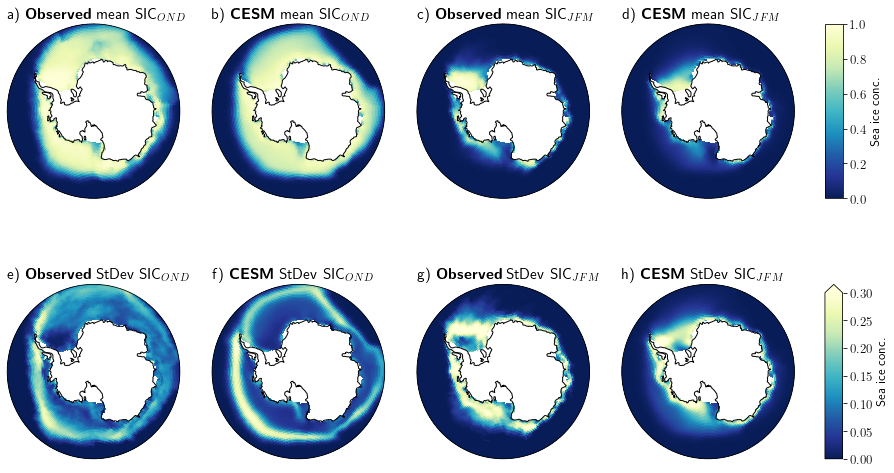

In [32]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1, 1, 1, 1, 0.1),height_ratios=(1,0.2,1))
cmap = 'YlGnBu_r'
prj =ccrs.SouthPolarStereo()

ax_mean_ond_obs = plt.subplot(gs[0, 0], projection=prj)
ax_mean_ond_cesm = plt.subplot(gs[0, 1], projection=prj)
ax_mean_jfm_obs = plt.subplot(gs[0, 2], projection=prj)
ax_mean_jfm_cesm = plt.subplot(gs[0, 3], projection=prj)

ax_std_ond_obs = plt.subplot(gs[2, 0], projection=prj)
ax_std_ond_cesm = plt.subplot(gs[2, 1], projection=prj)
ax_std_jfm_obs = plt.subplot(gs[2, 2], projection=prj)
ax_std_jfm_cesm = plt.subplot(gs[2, 3], projection=prj)

ax_cb_mean = plt.subplot(gs[0, 4])
ax_cb_std = plt.subplot(gs[2, 4])

######### OND mean
ax_mean_ond_obs.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_mean_ond_obs.set_title(r'a) \textbf{Observed} mean SIC$_{OND}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, sat_ice_ond_mean*0.01)
pc1=ax_mean_ond_obs.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=0,vmax=1, cmap=cmap)
ax_mean_ond_obs.coastlines('110m',linewidth=1)
ax_mean_ond_obs.set_boundary(circle, transform=ax_mean_ond_obs.transAxes)

ax_mean_ond_cesm.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_mean_ond_cesm.set_title(r'b) \textbf{CESM} mean SIC$_{OND}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, cesm_ice_ond_mean)
pc2 = ax_mean_ond_cesm.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=cmap,
                   vmin=0,vmax=1)
ax_mean_ond_cesm.coastlines('110m',linewidth=1)
ax_mean_ond_cesm.set_boundary(circle, transform=ax_mean_ond_cesm.transAxes)

######## JFM mean
ax_mean_jfm_obs.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_mean_jfm_obs.set_title(r'c) \textbf{Observed} mean SIC$_{JFM}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, sat_ice_jfm_mean*0.01)
pc1=ax_mean_jfm_obs.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=0,vmax=1, cmap=cmap)
ax_mean_jfm_obs.coastlines('110m',linewidth=1)
ax_mean_jfm_obs.set_boundary(circle, transform=ax_mean_jfm_obs.transAxes)

ax_mean_jfm_cesm.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_mean_jfm_cesm.set_title(r'd) \textbf{CESM} mean SIC$_{JFM}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, cesm_ice_jfm_mean)
pc2 = ax_mean_jfm_cesm.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=cmap,
                   vmin=0,vmax=1)
ax_mean_jfm_cesm.coastlines('110m',linewidth=1)
ax_mean_jfm_cesm.set_boundary(circle, transform=ax_mean_jfm_cesm.transAxes)

######## mean color bar

cbar1 = fig.colorbar(pc2, cax=ax_cb_mean, label='Sea ice conc.')


######### OND std
ax_std_ond_obs.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_std_ond_obs.set_title(r'e) \textbf{Observed} StDev SIC$_{OND}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, sat_ice_ond_std*0.01)
pc1=ax_std_ond_obs.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=0,vmax=0.3, cmap=cmap)
ax_std_ond_obs.coastlines('110m',linewidth=1)
ax_std_ond_obs.set_boundary(circle, transform=ax_std_ond_obs.transAxes)

ax_std_ond_cesm.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_std_ond_cesm.set_title(r'f) \textbf{CESM} StDev SIC$_{OND}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, cesm_ice_ond_std)
pc2 = ax_std_ond_cesm.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=cmap,
                   vmin=0,vmax=0.3)
ax_std_ond_cesm.coastlines('110m',linewidth=1)
ax_std_ond_cesm.set_boundary(circle, transform=ax_std_ond_cesm.transAxes)

######## JFM mean
ax_std_jfm_obs.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_std_jfm_obs.set_title(r'g) \textbf{Observed} StDev SIC$_{JFM}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, sat_ice_jfm_std*0.01)
pc1=ax_std_jfm_obs.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=0,vmax=0.3, cmap=cmap)
ax_std_jfm_obs.coastlines('110m',linewidth=1)
ax_std_jfm_obs.set_boundary(circle, transform=ax_std_jfm_obs.transAxes)

ax_std_jfm_cesm.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_std_jfm_cesm.set_title(r'h) \textbf{CESM} StDev SIC$_{JFM}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, cesm_ice_jfm_std)
pc2 = ax_std_jfm_cesm.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=cmap,
                   vmin=0,vmax=0.3)
ax_std_jfm_cesm.coastlines('110m',linewidth=1)
ax_std_jfm_cesm.set_boundary(circle, transform=ax_std_jfm_cesm.transAxes)

######## mean color bar

cbar2 = fig.colorbar(pc2, cax=ax_cb_std, extend='max', label='Sea ice conc.')

fig.savefig(f'{fig_dir}/FigS2_SIC_evaluation.png', bbox_inches='tight', dpi=300, format='png');

### NPP model validation

In [33]:
### Read in obs: VGPM and CbPM NPP algorithms (preprocessed obs in /glade/u/home/kristenk/diagnostics_MARBL/proc_obs/)

ds_vgpm_mean = xr.open_dataset(f'{obs_dir}/obs4diag/mean_VGPM_ONDJFM_2003-2020-061725.nc')
ds_cbpm_mean = xr.open_dataset(f'{obs_dir}/obs4diag/mean_CbPM_ONDJFM_2003-2020-061725.nc')
ds_cafe_mean = xr.open_dataset(f'{obs_dir}/obs4diag/mean_CAFE_ONDJFM_2003-2018-061725.nc')

In [34]:
### trim ds npp to 2003 to 2020, take ensemble mean

ds_npp = ds_npp.isel(time=slice(83,101)).mean(dim=('time','member_id'))

In [35]:
ds_npp['NPP_ONDJFM'] = ds_npp.NPP_ONDJFM/182 #making this time integral the mean over the growing season (Oct to Mar is 182 days)

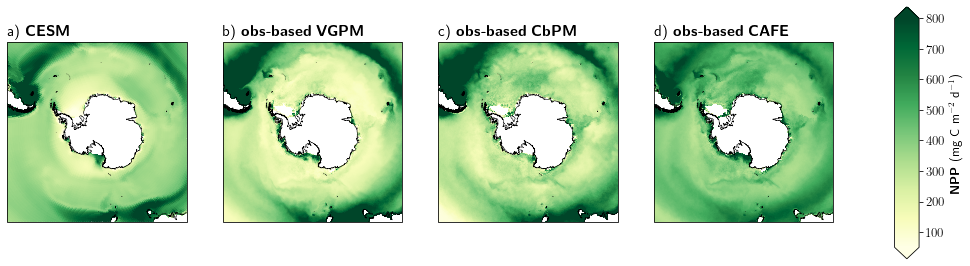

In [37]:
fig = plt.figure(figsize=(17,5))

import matplotlib.path as mpath

cmap ='YlGn'
#----------
ax = fig.add_subplot(1,4,1, projection=ccrs.SouthPolarStereo())
ax.set_title(r'a) \textbf{CESM}', loc='left')
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
lon,lat,field = utils.adjust_pop_grid(lons2, lats2, ds_npp.NPP_ONDJFM*12.011) #converting from mmol/m2/d to mg/m2/d

pc=ax.pcolormesh(lon, lat, field,
                 vmin=50, vmax=800,  
                 cmap=cmap,
                 transform=ccrs.PlateCarree())


ax = fig.add_subplot(1,4,2, projection=ccrs.SouthPolarStereo())
ax.set_title(r'b) \textbf{obs-based VGPM}', loc='left')
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(ds_vgpm_mean.lon, ds_vgpm_mean.lat, 
                 ds_vgpm_mean.NPP,
                 vmin=50, vmax=800, 
                 cmap=cmap,
                 transform=ccrs.PlateCarree())

#############################

ax = fig.add_subplot(1,4,3, projection=ccrs.SouthPolarStereo())
ax.set_title(r'c) \textbf{obs-based CbPM}', loc='left')
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(ds_cbpm_mean.lon, ds_cbpm_mean.lat, 
                 ds_cbpm_mean.npp,
                 vmin=50, vmax=800, 
                 cmap=cmap,
                 transform=ccrs.PlateCarree())


ax = fig.add_subplot(1,4,4, projection=ccrs.SouthPolarStereo())
ax.set_title(r'd) \textbf{obs-based CAFE}', loc='left')
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(ds_cafe_mean.lon, ds_cafe_mean.lat, 
                 ds_cafe_mean.CAFE_NPP_MODIS,
                 vmin=50, vmax=800, 
                 cmap=cmap,
                 transform=ccrs.PlateCarree())


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='both',label=r'\textbf{NPP} (mg C m$^{-2}$ d$^{-1}$)')

fig.savefig(f'{fig_dir}/FigS4_NPP_model_evaluation.png', bbox_inches='tight', dpi=300, format='png');

### Compare FEISTY fish biomass to distributions of toothfish and silverfish

In [38]:
file = f'{data_dir}/FEISTY_ann_tot_fish.nc'
ds_fish = xr.open_dataset(file)
#ds_fish = ds_fish.isel(nlat=slice(0,55))
ds_fish = ds_fish.isel(time=slice(70,250))
ds_fish

<xarray.Dataset>
Dimensions:             (fish: 8, group: 9, member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * fish                (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group               (group) object 'Sf' 'Sp' 'Sd' ... 'Ld' 'benthic_prey'
  * nlat                (nlat) int64 0 1 2 3 4 5 6 7 ... 47 48 49 50 51 52 53 54
  * nlon                (nlon) int64 0 1 2 3 4 5 6 ... 314 315 316 317 318 319
  * time                (time) int64 1920 1921 1922 1923 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id
Data variables:
    total_forage        (member_id, time, nlat, nlon) float64 ...
    total_pelagic       (member_id, time, nlat, nlon) float64 ...
    total_demersal      (member_id, time, nlat, nlon) float64 ...
    total_fish          (member_id, time, nlat, nlon) float64 ...
    total_forage_ice    (member_id, time, nlat, nlon) float64 ...
    total_pelagic_ice   (member_id, time, nlat, nlon) float64 ...
    total_demersal_ice  (member_id, time, nlat, nlon) float64 ...
    total_fish_ice      (member_id, time, nlat, nlon) float64 ...

In [39]:
tot_fish = ds_fish.total_fish.isel(time=slice(0,30)).mean(dim=('time','member_id'))

In [40]:
tot_fish

<xarray.DataArray 'total_fish' (nlat: 55, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.02777015, 0.03000818, 0.03282902, ...,        nan,        nan,
               nan],
       ...,
       [1.26679306, 1.25283288, 1.24039883, ..., 1.36587049, 1.29050082,
        1.27218193],
       [1.24549615, 1.22946915, 1.21924243, ..., 1.52016999, 1.338498  ,
        1.27425052],
       [1.23726829, 1.22507116, 1.21925412, ..., 1.54376591, 1.44726729,
        1.30602042]])
Coordinates:
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53 54
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

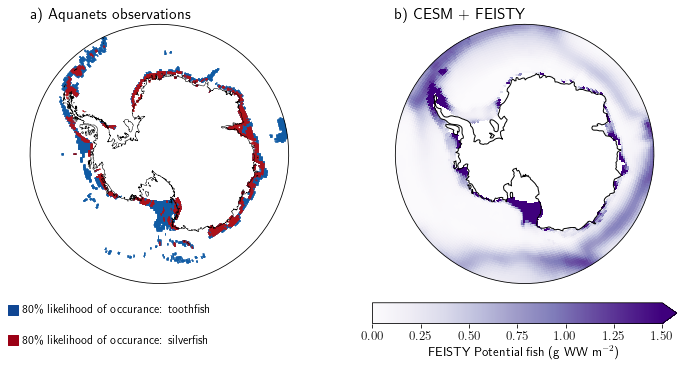

In [41]:
fig = plt.figure(figsize=(12,6))

gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=(1,1),height_ratios=(1,0.08,0.03))

prj =ccrs.SouthPolarStereo()

ax_map_aq = plt.subplot(gs[0,0], projection=prj)
ax_map_feisty = plt.subplot(gs[0,1], projection=prj)

cb_1 = plt.subplot(gs[1:3,0])
cb_2 = plt.subplot(gs[1,1])

##########################

ax_map_aq.set_extent([-180, 180, -90, -58], ccrs.PlateCarree())
ax_map_aq.set_title('a) Aquanets observations', loc='left')
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax_map_aq.set_boundary(circle, transform=ax_map_aq.transAxes)
#################### end circle
ax_map_aq.coastlines('10m',linewidth=0.5)
pc3 = ax_map_aq.pcolormesh(ds_aquamaps_toothfish.lon,ds_aquamaps_toothfish.lat,ds_aquamaps_toothfish.presence.where(ds_aquamaps_toothfish.presence==1),
                    transform=ccrs.PlateCarree(),
                   cmap='Blues',
                   vmin=0,vmax=1.2,alpha=0.4)
pc3 = ax_map_aq.pcolormesh(ds_aquamaps_silverfish.lon,ds_aquamaps_silverfish.lat,ds_aquamaps_silverfish.presence.where(ds_aquamaps_silverfish.presence==1),
                    transform=ccrs.PlateCarree(),
                   cmap='Reds',
                   vmin=0,vmax=1.2,alpha=0.3)
cb_1.set_axis_off()
cb_1.set_xlim(0,10)
cb_1.set_ylim(0,14)
cb_1.scatter(0.2,3,s=120,marker='s',clip_on='False', color=(155/255,0/255,21/255))
cb_1.text(0.5,2,r'80\% likelihood of occurance: silverfish',fontsize='12') #,clip_on='False')

cb_1.scatter(0.2,12,s=120,marker='s',clip_on='False', color=(16/255,70/255,147/255))
cb_1.text(0.5,11,r'80\% likelihood of occurance: toothfish',fontsize='12') #,clip_on='False')

########## 
ax_map_feisty.set_extent([-180, 180, -90, -58], ccrs.PlateCarree())
ax_map_feisty.set_title('b) CESM + FEISTY', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, tot_fish)
pc2 = ax_map_feisty.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='Purples',
                   vmin=0,vmax=1.5
                  )
ax_map_feisty.set_boundary(circle, transform=ax_map_feisty.transAxes)
ax_map_feisty.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc2, cax=cb_2, label='FEISTY Potential fish (g WW m$^{-2}$)', extend='max', orientation='horizontal')

fig.savefig(f'{fig_dir}/FigS8_fish_habitat_evaluation.png', bbox_inches='tight', dpi=300, format='png');


## Look at sea ice area in our seven regions

In [42]:
ones = np.full((55,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

### Antarctic peninsula tip
box1_latmin = -67
box1_latmax = -62
box1_lonmin = -64.
box1_lonmax = -53.

### East Antarctic
box2_latmin = -70
box2_latmax = -65
box2_lonmin = 12.
box2_lonmax = 30.

### Weddell sea 
box3_latmin = -80 #-79
box3_latmax = -72
box3_lonmin = -55 #-50.
box3_lonmax = -32.

### Terre Adelie
box4_latmin = -67
box4_latmax = -65
box4_lonmin = 136.
box4_lonmax = 142.

### Ross Sea
box5_latmin = -78
box5_latmax = -70
box5_lonmin = 165. ## these are in degrees East (crosses dateline)!!...so 170E to 160W
box5_lonmax = 200.

### Amundsen-Bellingshausen
box6_latmin = -75
box6_latmax = -68
box6_lonmin = -120.
box6_lonmax = -80.

### Prydz bay
box7_latmin = -70
box7_latmax = -65
box7_lonmin = 65.
box7_lonmax = 85.

In [43]:
mask1 = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
mask2 = ones.where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
mask3 = ones.where(lats<box3_latmax).where(lats>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
mask4 = ones.where(lats<box4_latmax).where(lats>box4_latmin).where(lons_norm<box4_lonmax).where(lons_norm>box4_lonmin)
## ross use deg east lons
mask5 = ones.where(lats<box5_latmax).where(lats>box5_latmin).where(lons<box5_lonmax).where(lons>box5_lonmin)
mask6 = ones.where(lats<box6_latmax).where(lats>box6_latmin).where(lons_norm<box6_lonmax).where(lons_norm>box6_lonmin)
mask7 = ones.where(lats<box7_latmax).where(lats>box7_latmin).where(lons_norm<box7_lonmax).where(lons_norm>box7_lonmin)

In [44]:
ts_AP_cesm = xr.Dataset()
ts_EAnt_cesm = xr.Dataset()
ts_Wedd_cesm = xr.Dataset()
ts_Adelie_cesm = xr.Dataset()
ts_Prydz_cesm = xr.Dataset()
ts_AmBel_cesm = xr.Dataset()
ts_Ross_cesm = xr.Dataset()
ts_SIZ_cesm = xr.Dataset()


for v in ['IFRAC_OND','IFRAC_JFM']:


    ######## Antarctic peninsula
    masked_area = area_km2.where(mask1==1)
    masked_fosi = ds_ice[v].where(mask1==1)
    masked_area['nlat'] = mask1.nlat
    masked_area['nlon'] = mask1.nlon
    ts_AP_cesm[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

    ######### do East Antarctica
    
    masked_area = area_km2.where(mask2==1)
    masked_area['nlat'] = mask2.nlat
    masked_area['nlon'] = mask2.nlon
    masked_fosi = ds_ice[v].where(mask2==1)
    ts_EAnt_cesm[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  Weddell
    masked_area = area_km2.where(mask3==1)
    masked_area['nlat'] = mask3.nlat
    masked_area['nlon'] = mask3.nlon
    masked_fosi = ds_ice[v].where(mask3==1)
    ts_Wedd_cesm[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  Terre Adelie
    masked_area = area_km2.where(mask4==1)
    masked_area['nlat'] = mask4.nlat
    masked_area['nlon'] = mask4.nlon
    masked_fosi = ds_ice[v].where(mask4==1)
    ts_Adelie_cesm[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    ######## Whole SIZ
    masked_area = area_km2.where(ds_siz_mask.SIZ==1)
    masked_area['nlat'] = ds_siz_mask.SIZ.nlat
    masked_area['nlon'] = ds_siz_mask.SIZ.nlon
    masked_fosi = ds_ice[v].where(ds_siz_mask.SIZ==1)
    ts_SIZ_cesm[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  Ross
    
    masked_area = area_km2.where(mask5==1)
    masked_area['nlat'] = mask5.nlat
    masked_area['nlon'] = mask5.nlon
    masked_fosi = ds_ice[v].where(mask5==1)
    ts_Ross_cesm[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  AmBel
    
    masked_area = area_km2.where(mask6==1)
    masked_area['nlat'] = mask6.nlat
    masked_area['nlon'] = mask6.nlon
    masked_fosi = ds_ice[v].where(mask6==1)
    ts_AmBel_cesm[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  Prydz
    
    masked_area = area_km2.where(mask7==1)
    masked_area['nlat'] = mask7.nlat
    masked_area['nlon'] = mask7.nlon
    masked_fosi = ds_ice[v].where(mask7==1)
    ts_Prydz_cesm[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

In [45]:
ds_sat_ice_seas = xr.Dataset()
ds_sat_ice_seas['sic_jfm'] = sat_ice_jfm
ds_sat_ice_seas['sic_ond'] = sat_ice_ond
ds_sat_ice_seas['time'] = sat_ice_ond['time']
ds_sat_ice_seas = ds_sat_ice_seas.rename({'lat' : 'nlat'})
ds_sat_ice_seas = ds_sat_ice_seas.rename({'lon' : 'nlon'})
ds_sat_ice_seas['nlat'] = ds_ice['nlat']
ds_sat_ice_seas['nlon'] = ds_ice['nlon']

In [46]:
ds_sat_ice_seas

<xarray.Dataset>
Dimensions:  (nlat: 55, nlon: 320, time: 42)
Coordinates:
  * time     (time) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019 2020
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53 54
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
Data variables:
    sic_jfm  (time, nlat, nlon) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    sic_ond  (time, nlat, nlon) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0

In [47]:
ds_sat_ice_seas = ds_sat_ice_seas.load()

In [48]:
ts_AP_cdr = xr.Dataset()
ts_EAnt_cdr = xr.Dataset()
ts_Wedd_cdr = xr.Dataset()
ts_Adelie_cdr = xr.Dataset()
ts_Prydz_cdr = xr.Dataset()
ts_AmBel_cdr = xr.Dataset()
ts_Ross_cdr = xr.Dataset()
ts_SIZ_cdr = xr.Dataset()


for v in ['sic_jfm','sic_ond']:


    ######## Antarctic peninsula
    masked_area = area_km2.where(mask1==1)
    masked_fosi = ds_sat_ice_seas[v].where(mask1==1)
    masked_area['nlat'] = mask1.nlat
    masked_area['nlon'] = mask1.nlon
    ts_AP_cdr[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

    ######### do East Antarctica
    
    masked_area = area_km2.where(mask2==1)
    masked_area['nlat'] = mask2.nlat
    masked_area['nlon'] = mask2.nlon
    masked_fosi = ds_sat_ice_seas[v].where(mask2==1)
    ts_EAnt_cdr[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  Weddell
    masked_area = area_km2.where(mask3==1)
    masked_area['nlat'] = mask3.nlat
    masked_area['nlon'] = mask3.nlon
    masked_fosi = ds_sat_ice_seas[v].where(mask3==1)
    ts_Wedd_cdr[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  Terre Adelie
    masked_area = area_km2.where(mask4==1)
    masked_area['nlat'] = mask4.nlat
    masked_area['nlon'] = mask4.nlon
    masked_fosi = ds_sat_ice_seas[v].where(mask4==1)
    ts_Adelie_cdr[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    ######## Whole SIZ
    masked_area = area_km2.where(ds_siz_mask.SIZ==1)
    masked_area['nlat'] = ds_siz_mask.SIZ.nlat
    masked_area['nlon'] = ds_siz_mask.SIZ.nlon
    masked_fosi = ds_sat_ice_seas[v].where(ds_siz_mask.SIZ==1)
    ts_SIZ_cdr[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  Ross
    
    masked_area = area_km2.where(mask5==1)
    masked_area['nlat'] = mask5.nlat
    masked_area['nlon'] = mask5.nlon
    masked_fosi = ds_sat_ice_seas[v].where(mask5==1)
    ts_Ross_cdr[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  AmBel
    
    masked_area = area_km2.where(mask6==1)
    masked_area['nlat'] = mask6.nlat
    masked_area['nlon'] = mask6.nlon
    masked_fosi = ds_sat_ice_seas[v].where(mask6==1)
    ts_AmBel_cdr[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  Prydz
    
    masked_area = area_km2.where(mask7==1)
    masked_area['nlat'] = mask7.nlat
    masked_area['nlon'] = mask7.nlon
    masked_fosi = ds_sat_ice_seas[v].where(mask7==1)
    ts_Prydz_cdr[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

In [49]:
ds_regs_ONDmean_cesm = xr.Dataset()
ds_regs_ONDstd_cesm = xr.Dataset()

ds_regs_ONDmean_cesm['SIZ'] = ts_SIZ_cesm['IFRAC_OND_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_ONDstd_cesm['SIZ'] = ts_SIZ_cesm['IFRAC_OND_SIA_km2'].std(dim=('time','member_id'))

ds_regs_ONDmean_cesm['AP'] = ts_AP_cesm['IFRAC_OND_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_ONDstd_cesm['AP'] = ts_AP_cesm['IFRAC_OND_SIA_km2'].std(dim=('time','member_id'))

ds_regs_ONDmean_cesm['Wedd'] = ts_Wedd_cesm['IFRAC_OND_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_ONDstd_cesm['Wedd'] = ts_Wedd_cesm['IFRAC_OND_SIA_km2'].std(dim=('time','member_id'))

ds_regs_ONDmean_cesm['EAnt'] = ts_EAnt_cesm['IFRAC_OND_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_ONDstd_cesm['EAnt'] = ts_EAnt_cesm['IFRAC_OND_SIA_km2'].std(dim=('time','member_id'))

ds_regs_ONDmean_cesm['Prydz'] = ts_Prydz_cesm['IFRAC_OND_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_ONDstd_cesm['Prydz'] = ts_Prydz_cesm['IFRAC_OND_SIA_km2'].std(dim=('time','member_id'))

ds_regs_ONDmean_cesm['Adelie'] = ts_Adelie_cesm['IFRAC_OND_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_ONDstd_cesm['Adelie'] = ts_Adelie_cesm['IFRAC_OND_SIA_km2'].std(dim=('time','member_id'))

ds_regs_ONDmean_cesm['Ross'] = ts_Ross_cesm['IFRAC_OND_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_ONDstd_cesm['Ross'] = ts_Ross_cesm['IFRAC_OND_SIA_km2'].std(dim=('time','member_id'))

ds_regs_ONDmean_cesm['AmBel'] = ts_AmBel_cesm['IFRAC_OND_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_ONDstd_cesm['AmBel'] = ts_AmBel_cesm['IFRAC_OND_SIA_km2'].std(dim=('time','member_id'))

In [50]:
ds_regs_JFMmean_cesm = xr.Dataset()
ds_regs_JFMstd_cesm = xr.Dataset()

ds_regs_JFMmean_cesm['SIZ'] = ts_SIZ_cesm['IFRAC_JFM_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_JFMstd_cesm['SIZ'] = ts_SIZ_cesm['IFRAC_JFM_SIA_km2'].std(dim=('time','member_id'))

ds_regs_JFMmean_cesm['AP'] = ts_AP_cesm['IFRAC_JFM_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_JFMstd_cesm['AP'] = ts_AP_cesm['IFRAC_JFM_SIA_km2'].std(dim=('time','member_id'))

ds_regs_JFMmean_cesm['Wedd'] = ts_Wedd_cesm['IFRAC_JFM_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_JFMstd_cesm['Wedd'] = ts_Wedd_cesm['IFRAC_JFM_SIA_km2'].std(dim=('time','member_id'))

ds_regs_JFMmean_cesm['EAnt'] = ts_EAnt_cesm['IFRAC_JFM_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_JFMstd_cesm['EAnt'] = ts_EAnt_cesm['IFRAC_JFM_SIA_km2'].std(dim=('time','member_id'))

ds_regs_JFMmean_cesm['Prydz'] = ts_Prydz_cesm['IFRAC_JFM_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_JFMstd_cesm['Prydz'] = ts_Prydz_cesm['IFRAC_JFM_SIA_km2'].std(dim=('time','member_id'))

ds_regs_JFMmean_cesm['Adelie'] = ts_Adelie_cesm['IFRAC_JFM_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_JFMstd_cesm['Adelie'] = ts_Adelie_cesm['IFRAC_JFM_SIA_km2'].std(dim=('time','member_id'))

ds_regs_JFMmean_cesm['Ross'] = ts_Ross_cesm['IFRAC_JFM_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_JFMstd_cesm['Ross'] = ts_Ross_cesm['IFRAC_JFM_SIA_km2'].std(dim=('time','member_id'))

ds_regs_JFMmean_cesm['AmBel'] = ts_AmBel_cesm['IFRAC_JFM_SIA_km2'].mean(dim=('time','member_id'))
ds_regs_JFMstd_cesm['AmBel'] = ts_AmBel_cesm['IFRAC_JFM_SIA_km2'].std(dim=('time','member_id'))

In [51]:
ds_regs_ONDmean_cdr = xr.Dataset()
ds_regs_ONDstd_cdr = xr.Dataset()

ds_regs_ONDmean_cdr['SIZ'] = ts_SIZ_cdr['sic_ond_SIA_km2'].mean(dim='time')
ds_regs_ONDstd_cdr['SIZ'] = ts_SIZ_cdr['sic_ond_SIA_km2'].std(dim='time')

ds_regs_ONDmean_cdr['AP'] = ts_AP_cdr['sic_ond_SIA_km2'].mean(dim='time')
ds_regs_ONDstd_cdr['AP'] = ts_AP_cdr['sic_ond_SIA_km2'].std(dim='time')

ds_regs_ONDmean_cdr['Wedd'] = ts_Wedd_cdr['sic_ond_SIA_km2'].mean(dim='time')
ds_regs_ONDstd_cdr['Wedd'] = ts_Wedd_cdr['sic_ond_SIA_km2'].std(dim='time')

ds_regs_ONDmean_cdr['EAnt'] = ts_EAnt_cdr['sic_ond_SIA_km2'].mean(dim='time')
ds_regs_ONDstd_cdr['EAnt'] = ts_EAnt_cdr['sic_ond_SIA_km2'].std(dim='time')

ds_regs_ONDmean_cdr['Prydz'] = ts_Prydz_cdr['sic_ond_SIA_km2'].mean(dim='time')
ds_regs_ONDstd_cdr['Prydz'] = ts_Prydz_cdr['sic_ond_SIA_km2'].std(dim='time')

ds_regs_ONDmean_cdr['Adelie'] = ts_Adelie_cdr['sic_ond_SIA_km2'].mean(dim='time')
ds_regs_ONDstd_cdr['Adelie'] = ts_Adelie_cdr['sic_ond_SIA_km2'].std(dim='time')

ds_regs_ONDmean_cdr['Ross'] = ts_Ross_cdr['sic_ond_SIA_km2'].mean(dim='time')
ds_regs_ONDstd_cdr['Ross'] = ts_Ross_cdr['sic_ond_SIA_km2'].std(dim='time')

ds_regs_ONDmean_cdr['AmBel'] = ts_AmBel_cdr['sic_ond_SIA_km2'].mean(dim='time')
ds_regs_ONDstd_cdr['AmBel'] = ts_AmBel_cdr['sic_ond_SIA_km2'].std(dim='time')

In [52]:
ds_regs_JFMmean_cdr = xr.Dataset()
ds_regs_JFMstd_cdr = xr.Dataset()

ds_regs_JFMmean_cdr['SIZ'] = ts_SIZ_cdr['sic_jfm_SIA_km2'].mean(dim='time')
ds_regs_JFMstd_cdr['SIZ'] = ts_SIZ_cdr['sic_jfm_SIA_km2'].std(dim='time')

ds_regs_JFMmean_cdr['AP'] = ts_AP_cdr['sic_jfm_SIA_km2'].mean(dim='time')
ds_regs_JFMstd_cdr['AP'] = ts_AP_cdr['sic_jfm_SIA_km2'].std(dim='time')

ds_regs_JFMmean_cdr['Wedd'] = ts_Wedd_cdr['sic_jfm_SIA_km2'].mean(dim='time')
ds_regs_JFMstd_cdr['Wedd'] = ts_Wedd_cdr['sic_jfm_SIA_km2'].std(dim='time')

ds_regs_JFMmean_cdr['EAnt'] = ts_EAnt_cdr['sic_jfm_SIA_km2'].mean(dim='time')
ds_regs_JFMstd_cdr['EAnt'] = ts_EAnt_cdr['sic_jfm_SIA_km2'].std(dim='time')

ds_regs_JFMmean_cdr['Prydz'] = ts_Prydz_cdr['sic_jfm_SIA_km2'].mean(dim='time')
ds_regs_JFMstd_cdr['Prydz'] = ts_Prydz_cdr['sic_jfm_SIA_km2'].std(dim='time')

ds_regs_JFMmean_cdr['Adelie'] = ts_Adelie_cdr['sic_jfm_SIA_km2'].mean(dim='time')
ds_regs_JFMstd_cdr['Adelie'] = ts_Adelie_cdr['sic_jfm_SIA_km2'].std(dim='time')

ds_regs_JFMmean_cdr['Ross'] = ts_Ross_cdr['sic_jfm_SIA_km2'].mean(dim='time')
ds_regs_JFMstd_cdr['Ross'] = ts_Ross_cdr['sic_jfm_SIA_km2'].std(dim='time')

ds_regs_JFMmean_cdr['AmBel'] = ts_AmBel_cdr['sic_jfm_SIA_km2'].mean(dim='time')
ds_regs_JFMstd_cdr['AmBel'] = ts_AmBel_cdr['sic_jfm_SIA_km2'].std(dim='time')

### Make a bar graph of sea ice area in different regions

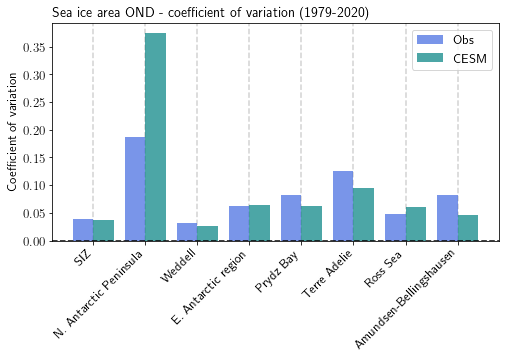

In [53]:
fig = plt.figure(figsize=(8,4))

labels = ['SIZ','N. Antarctic Peninsula','Weddell','E. Antarctic region','Prydz Bay','Terre Adelie','Ross Sea','Amundsen-Bellingshausen']

inds = np.arange(0,len(labels))

var = 'sic_ond_SIA_km2'
valsONDcdr = [ds_regs_ONDstd_cdr['SIZ'].values/ds_regs_ONDmean_cdr['SIZ'].values,
       ds_regs_ONDstd_cdr['AP'].values/ds_regs_ONDmean_cdr['AP'].values,
       ds_regs_ONDstd_cdr['Wedd'].values/ds_regs_ONDmean_cdr['Wedd'].values,
       ds_regs_ONDstd_cdr['EAnt'].values/ds_regs_ONDmean_cdr['EAnt'].values,
       ds_regs_ONDstd_cdr['Prydz'].values/ds_regs_ONDmean_cdr['Prydz'].values,
       ds_regs_ONDstd_cdr['Adelie'].values/ds_regs_ONDmean_cdr['Adelie'].values,
       ds_regs_ONDstd_cdr['Ross'].values/ds_regs_ONDmean_cdr['Ross'].values,
       ds_regs_ONDstd_cdr['AmBel'].values/ds_regs_ONDmean_cdr['AmBel'].values]

var = 'IFRAC_OND_SIA_km2'
valsONDcesm = [ds_regs_ONDstd_cesm['SIZ'].values/ds_regs_ONDmean_cesm['SIZ'].values,
       ds_regs_ONDstd_cesm['AP'].values/ds_regs_ONDmean_cesm['AP'].values,
       ds_regs_ONDstd_cesm['Wedd'].values/ds_regs_ONDmean_cesm['Wedd'].values,
       ds_regs_ONDstd_cesm['EAnt'].values/ds_regs_ONDmean_cesm['EAnt'].values,
       ds_regs_ONDstd_cesm['Prydz'].values/ds_regs_ONDmean_cesm['Prydz'].values,
       ds_regs_ONDstd_cesm['Adelie'].values/ds_regs_ONDmean_cesm['Adelie'].values,
       ds_regs_ONDstd_cesm['Ross'].values/ds_regs_ONDmean_cesm['Ross'].values,
       ds_regs_ONDstd_cesm['AmBel'].values/ds_regs_ONDmean_cesm['AmBel'].values]

ax = fig.add_subplot(1,1,1)

ax.bar(inds-0.2, valsONDcdr, color='royalblue',width=0.4,alpha=0.7, label='Obs')
ax.bar(inds+0.2, valsONDcesm, color='teal',width=0.4,alpha=0.7, label='CESM')
ax.set_title('Sea ice area OND - coefficient of variation (1979-2020)',fontsize=14,loc='left')
ax.set_ylabel('Coefficient of variation')
plt.xticks(inds, labels,rotation=45, ha='right');
ax.axhline(0,linestyle='--',color='black')
for i in inds:
    ax.axvline(inds[i],linestyle='--',color='lightgray',zorder=0)
ax.legend()

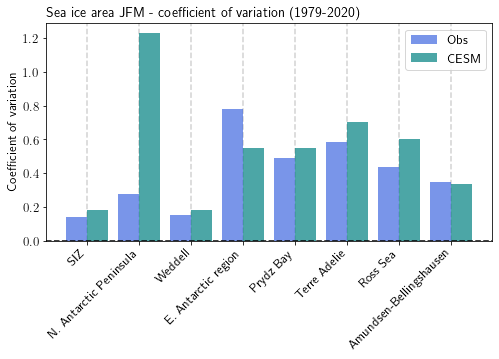

In [54]:
fig = plt.figure(figsize=(8,4))

labels = ['SIZ','N. Antarctic Peninsula','Weddell','E. Antarctic region','Prydz Bay','Terre Adelie','Ross Sea','Amundsen-Bellingshausen']

inds = np.arange(0,len(labels))

var = 'sic_jfm_SIA_km2'
valsONDcdr = [ds_regs_JFMstd_cdr['SIZ'].values/ds_regs_JFMmean_cdr['SIZ'].values,
       ds_regs_JFMstd_cdr['AP'].values/ds_regs_JFMmean_cdr['AP'].values,
       ds_regs_JFMstd_cdr['Wedd'].values/ds_regs_JFMmean_cdr['Wedd'].values,
       ds_regs_JFMstd_cdr['EAnt'].values/ds_regs_JFMmean_cdr['EAnt'].values,
       ds_regs_JFMstd_cdr['Prydz'].values/ds_regs_JFMmean_cdr['Prydz'].values,
       ds_regs_JFMstd_cdr['Adelie'].values/ds_regs_JFMmean_cdr['Adelie'].values,
       ds_regs_JFMstd_cdr['Ross'].values/ds_regs_JFMmean_cdr['Ross'].values,
       ds_regs_JFMstd_cdr['AmBel'].values/ds_regs_JFMmean_cdr['AmBel'].values]

var = 'IFRAC_OND_SIA_km2'
valsONDcesm = [ds_regs_JFMstd_cesm['SIZ'].values/ds_regs_JFMmean_cesm['SIZ'].values,
       ds_regs_JFMstd_cesm['AP'].values/ds_regs_JFMmean_cesm['AP'].values,
       ds_regs_JFMstd_cesm['Wedd'].values/ds_regs_JFMmean_cesm['Wedd'].values,
       ds_regs_JFMstd_cesm['EAnt'].values/ds_regs_JFMmean_cesm['EAnt'].values,
       ds_regs_JFMstd_cesm['Prydz'].values/ds_regs_JFMmean_cesm['Prydz'].values,
       ds_regs_JFMstd_cesm['Adelie'].values/ds_regs_JFMmean_cesm['Adelie'].values,
       ds_regs_JFMstd_cesm['Ross'].values/ds_regs_JFMmean_cesm['Ross'].values,
       ds_regs_JFMstd_cesm['AmBel'].values/ds_regs_JFMmean_cesm['AmBel'].values]

ax = fig.add_subplot(1,1,1)

ax.bar(inds-0.2, valsONDcdr, color='royalblue',width=0.4,alpha=0.7, label='Obs')
ax.bar(inds+0.2, valsONDcesm, color='teal',width=0.4,alpha=0.7, label='CESM')
ax.set_title('Sea ice area JFM - coefficient of variation (1979-2020)',fontsize=14,loc='left')
ax.set_ylabel('Coefficient of variation')
plt.xticks(inds, labels,rotation=45, ha='right');
ax.axhline(0,linestyle='--',color='black')
for i in inds:
    ax.axvline(inds[i],linestyle='--',color='lightgray',zorder=0)
ax.legend()

### Combine both seasons into one figure

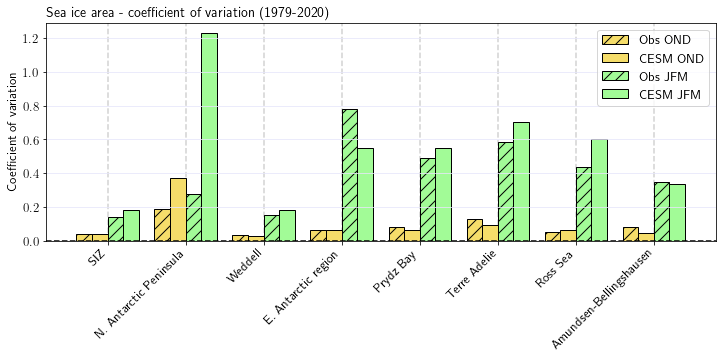

In [55]:
spr_color = (245/255,221/255,106/255)

sum_color = (162/255,251/255,151/255)

fig = plt.figure(figsize=(12,4))

labels = ['SIZ','N. Antarctic Peninsula','Weddell','E. Antarctic region','Prydz Bay','Terre Adelie','Ross Sea','Amundsen-Bellingshausen']

inds = np.arange(0,len(labels))

var = 'sic_ond_SIA_km2'
valsONDcdr = [ds_regs_ONDstd_cdr['SIZ'].values/ds_regs_ONDmean_cdr['SIZ'].values,
       ds_regs_ONDstd_cdr['AP'].values/ds_regs_ONDmean_cdr['AP'].values,
       ds_regs_ONDstd_cdr['Wedd'].values/ds_regs_ONDmean_cdr['Wedd'].values,
       ds_regs_ONDstd_cdr['EAnt'].values/ds_regs_ONDmean_cdr['EAnt'].values,
       ds_regs_ONDstd_cdr['Prydz'].values/ds_regs_ONDmean_cdr['Prydz'].values,
       ds_regs_ONDstd_cdr['Adelie'].values/ds_regs_ONDmean_cdr['Adelie'].values,
       ds_regs_ONDstd_cdr['Ross'].values/ds_regs_ONDmean_cdr['Ross'].values,
       ds_regs_ONDstd_cdr['AmBel'].values/ds_regs_ONDmean_cdr['AmBel'].values]

var = 'IFRAC_OND_SIA_km2'
valsONDcesm = [ds_regs_ONDstd_cesm['SIZ'].values/ds_regs_ONDmean_cesm['SIZ'].values,
       ds_regs_ONDstd_cesm['AP'].values/ds_regs_ONDmean_cesm['AP'].values,
       ds_regs_ONDstd_cesm['Wedd'].values/ds_regs_ONDmean_cesm['Wedd'].values,
       ds_regs_ONDstd_cesm['EAnt'].values/ds_regs_ONDmean_cesm['EAnt'].values,
       ds_regs_ONDstd_cesm['Prydz'].values/ds_regs_ONDmean_cesm['Prydz'].values,
       ds_regs_ONDstd_cesm['Adelie'].values/ds_regs_ONDmean_cesm['Adelie'].values,
       ds_regs_ONDstd_cesm['Ross'].values/ds_regs_ONDmean_cesm['Ross'].values,
       ds_regs_ONDstd_cesm['AmBel'].values/ds_regs_ONDmean_cesm['AmBel'].values]

var = 'sic_jfm_SIA_km2'
valsJFMcdr = [ds_regs_JFMstd_cdr['SIZ'].values/ds_regs_JFMmean_cdr['SIZ'].values,
       ds_regs_JFMstd_cdr['AP'].values/ds_regs_JFMmean_cdr['AP'].values,
       ds_regs_JFMstd_cdr['Wedd'].values/ds_regs_JFMmean_cdr['Wedd'].values,
       ds_regs_JFMstd_cdr['EAnt'].values/ds_regs_JFMmean_cdr['EAnt'].values,
       ds_regs_JFMstd_cdr['Prydz'].values/ds_regs_JFMmean_cdr['Prydz'].values,
       ds_regs_JFMstd_cdr['Adelie'].values/ds_regs_JFMmean_cdr['Adelie'].values,
       ds_regs_JFMstd_cdr['Ross'].values/ds_regs_JFMmean_cdr['Ross'].values,
       ds_regs_JFMstd_cdr['AmBel'].values/ds_regs_JFMmean_cdr['AmBel'].values]

var = 'IFRAC_OND_SIA_km2'
valsJFMcesm = [ds_regs_JFMstd_cesm['SIZ'].values/ds_regs_JFMmean_cesm['SIZ'].values,
       ds_regs_JFMstd_cesm['AP'].values/ds_regs_JFMmean_cesm['AP'].values,
       ds_regs_JFMstd_cesm['Wedd'].values/ds_regs_JFMmean_cesm['Wedd'].values,
       ds_regs_JFMstd_cesm['EAnt'].values/ds_regs_JFMmean_cesm['EAnt'].values,
       ds_regs_JFMstd_cesm['Prydz'].values/ds_regs_JFMmean_cesm['Prydz'].values,
       ds_regs_JFMstd_cesm['Adelie'].values/ds_regs_JFMmean_cesm['Adelie'].values,
       ds_regs_JFMstd_cesm['Ross'].values/ds_regs_JFMmean_cesm['Ross'].values,
       ds_regs_JFMstd_cesm['AmBel'].values/ds_regs_JFMmean_cesm['AmBel'].values]

ax = fig.add_subplot(1,1,1)
ax.yaxis.grid(True, which='major',color='lavender')
ax.bar(inds-0.3, valsONDcdr, color=spr_color,width=0.2, edgecolor='black', hatch='//', label='Obs OND')
ax.bar(inds-0.1, valsONDcesm, color=spr_color,width=0.2, edgecolor='black', label='CESM OND')
ax.bar(inds+0.1, valsJFMcdr, color=sum_color,width=0.2, edgecolor='black', hatch='//', label='Obs JFM')
ax.bar(inds+0.3, valsJFMcesm, color=sum_color,width=0.2, edgecolor='black', label='CESM JFM')


ax.set_title('Sea ice area - coefficient of variation (1979-2020)',fontsize=14,loc='left')
ax.set_ylabel('Coefficient of variation')
plt.xticks(inds, labels,rotation=45, ha='right');
ax.axhline(0,linestyle='--',color='black')
for i in inds:
    ax.axvline(inds[i],linestyle='--',color='lightgray',zorder=0)
ax.legend()

fig.savefig('/glade/work/kristenk/figs/FigS12_coeff_var_SIA_satperiod.png', bbox_inches='tight', dpi=300, format='png');

### Write these regional data out so I can combine this figure with the one for the base period

In [56]:
ds_regs_ONDstd_cdr.to_netcdf(f'{data_dir}/reg_data/ds_regs_ONDstd_cdr.nc')
ds_regs_ONDmean_cdr.to_netcdf(f'{data_dir}/reg_data/ds_regs_ONDmean_cdr.nc')

ds_regs_JFMstd_cdr.to_netcdf(f'{data_dir}/reg_data/ds_regs_JFMstd_cdr.nc')
ds_regs_JFMmean_cdr.to_netcdf(f'{data_dir}/reg_data/ds_regs_JFMmean_cdr.nc')

ds_regs_ONDstd_cesm.to_netcdf(f'{data_dir}/reg_data/ds_regs_ONDstd_cesm.nc')
ds_regs_ONDmean_cesm.to_netcdf(f'{data_dir}/reg_data/ds_regs_ONDmean_cesm.nc')

ds_regs_JFMstd_cesm.to_netcdf(f'{data_dir}/reg_data/ds_regs_JFMstd_cesm.nc')
ds_regs_JFMmean_cesm.to_netcdf(f'{data_dir}/reg_data/ds_regs_JFMmean_cesm.nc')